In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import ast
import matplotlib.pyplot as plt

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Transforms for training and testing. We use the CIFAR 10 means
# and stdevs from https://github.com/facebookarchive/fb.resnet.torch/issues/180


train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),             # resize shortest side to 40 pixels
        transforms.CenterCrop(32),         # crop longest side to 32 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447],
                             [0.247, 0.243, 0.262])
    ])

test_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.491, 0.482, 0.447],
                             [0.247, 0.243, 0.262])
    ])


# Load the CIFAR-10 dataset

train_dataset = datasets.CIFAR10(root='./data', transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', transform=test_transform, train=False, download=True)

# Category labels

cat_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Create data loaders from train/test datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


In [3]:
from tqdm import tqdm

# Load the GoogLeNet model with pretrained weights and modify it to classify CIFAR-10

model = models.googlenet(pretrained=True)

model.fc = torch.nn.Linear(1024, 10, bias=True)


# Set up early stopping parameters
patience = 3
best_loss = float('inf')
counter = 0

# Training loop

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = model.to(device)
num_epochs = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(num_epochs):
    # Iterate over the training data loader
    model.train()
    epoch_loss = 0
    iters = 0
    correct = 0 
    for inputs, targets in tqdm(train_dataloader):
        model.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        epoch_loss += loss.cpu().item()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iters += 1
        train_loss = epoch_loss / iters

    # Record training loss
    train_losses.append(train_loss)
    # Record training accuracy
    train_acc.append(100 * correct / len(train_dataloader.dataset))

    #print('Epoch %d training loss %f' % (epoch, train_loss))
    
    #Testing
    model.eval()
    epoch_loss = 0
    iters = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.cpu().item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets.data).sum()
            iters += 1
            test_loss = epoch_loss / iters

    # Record validation loss
    test_losses.append(test_loss)
    # Record validation accuracy
    test_acc.append(100 * correct / len(test_dataloader.dataset))
    
    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_weights = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch} epochs.')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train loss {train_loss:.4f}, Train acc {train_acc[-1]:.2f}, Test loss {test_loss:.4f}, Test acc {test_acc[-1]:.2f}')




100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 1/20, Train loss 0.4948, Train acc 83.30, Test loss 0.2293, Test acc 91.81


100%|██████████| 79/79 [00:34<00:00,  2.28it/s]


Epoch 2/20, Train loss 0.2188, Train acc 92.36, Test loss 0.1732, Test acc 93.90


100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 3/20, Train loss 0.1601, Train acc 94.53, Test loss 0.1673, Test acc 94.09


100%|██████████| 79/79 [00:40<00:00,  1.97it/s]


Epoch 4/20, Train loss 0.1302, Train acc 95.52, Test loss 0.1442, Test acc 94.90


100%|██████████| 79/79 [00:44<00:00,  1.78it/s]


Epoch 5/20, Train loss 0.1124, Train acc 96.12, Test loss 0.1599, Test acc 94.63


100%|██████████| 79/79 [00:44<00:00,  1.79it/s]


Epoch 6/20, Train loss 0.0943, Train acc 96.82, Test loss 0.1589, Test acc 94.72


100%|██████████| 79/79 [00:44<00:00,  1.78it/s]


Epoch 7/20, Train loss 0.0828, Train acc 97.17, Test loss 0.1431, Test acc 95.15


100%|██████████| 79/79 [00:42<00:00,  1.86it/s]


Epoch 8/20, Train loss 0.0724, Train acc 97.53, Test loss 0.1460, Test acc 95.30


100%|██████████| 79/79 [00:31<00:00,  2.48it/s]


Epoch 9/20, Train loss 0.0666, Train acc 97.68, Test loss 0.1517, Test acc 95.22


100%|██████████| 79/79 [00:26<00:00,  2.94it/s]

Early stopping after 9 epochs.


### Visualize Loss 

<function matplotlib.pyplot.show(close=None, block=None)>

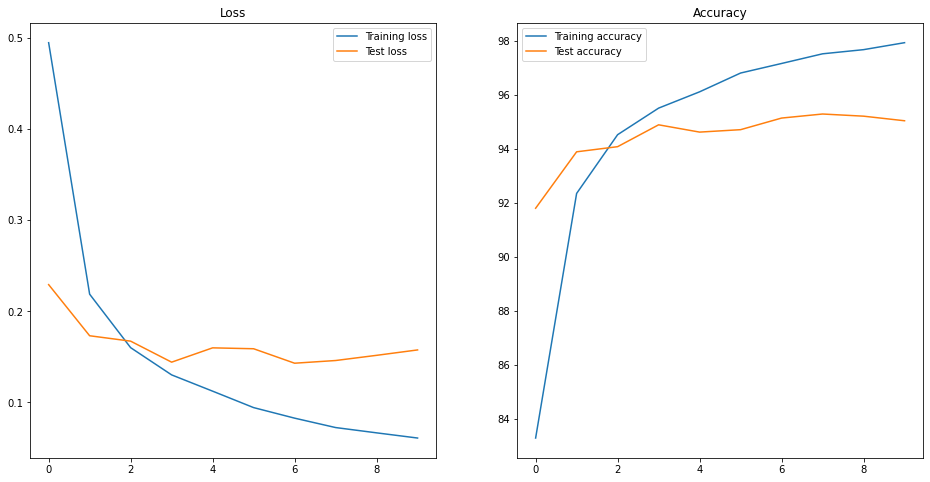

In [4]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc], label='Training accuracy')
plt.plot([x.cpu() for x in test_acc], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

### Display some images in Testset with actual & predicted labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


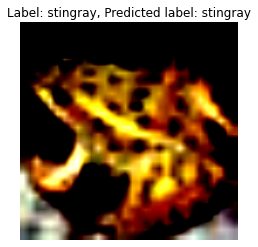

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


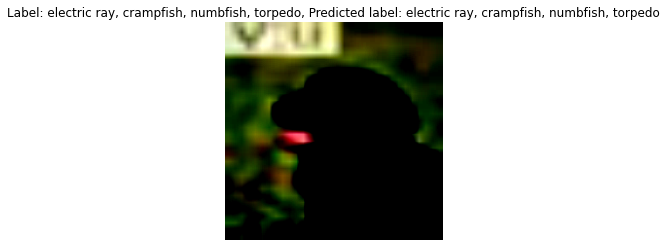

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


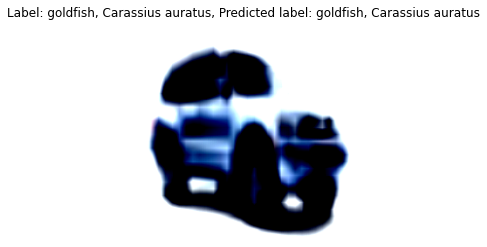

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


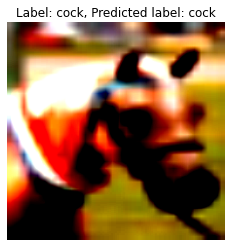

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


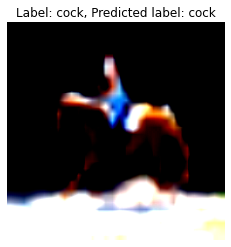

In [5]:
# Get ImageNet class labels
with open('imagenet1000_clsidx_to_labels.txt') as f:
    label_data = f.read()
class_labels = ast.literal_eval(label_data)

# Select a random image from the dataset
import numpy as np
idx = np.arange(len(test_dataset))
np.random.shuffle(idx)
for x in range(5):
    inputs, label = test_dataset[idx[x]]
    output = model(inputs.to(device).unsqueeze(0) )
    _, predicted_label = torch.max(output.data, 1)
    plt.imshow(np.transpose(inputs.numpy(), (1, 2, 0)))
    plt.title(f"Label: {class_labels[label]}, Predicted label: {class_labels[predicted_label.item()]}")
    plt.axis('off')
    plt.show()